In [67]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import TqdmWarning

from rfc.index.backends.spacy import (
    SpaCyTfidfVectorizer,
    download_if_not_exists,
)
from rfc.index.base import DocQuery, NameQuery, UrlQuery
from rfc.index.tfidf import TfidfIndex
from rfc.scrap import scrap
from rfc.storage.tfidf import TfidfStorage
from rfc.utils.logging import Logger

warnings.filterwarnings(
    module="tqdm.auto", action="ignore", category=TqdmWarning
)
warnings.filterwarnings(
    module="sklearn.feature_extraction.text",
    action="ignore",
    category=UserWarning,
)
warnings.filterwarnings(action="ignore", category=FutureWarning)
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Request For Comments (RFC)

Authors:
* Vasyl Korzavatykh 158669
* Andrii Chmutov 154974

A **Request for Comments** (RFC) is a publication in a series from the principal technical development and standards-setting bodies for the Internet, most prominently the **Internet Engineering Task Force** (IETF). An RFC is authored by individuals or groups of engineers and computer scientists in the form of a memorandum describing methods, behaviors, research, or innovations applicable to the working of the Internet and Internet-connected systems. It is submitted either for peer review or to convey new concepts, information, or, occasionally, engineering humor.

Our bespoke implementation of search system aims to simplify the process of navigating the website and kick-off the user experience to the next level.

## Configuration

Configure the Project Report with the following parameters:

In [2]:
load_docs = True
load_index = True

db = "huge.sqlite"
loglevel = "INFO"
vectorizer_path = "huge.pkl"
nlp_model = "en_core_web_sm"
limit: int = 5
starting_nodes = [
    "https://datatracker.ietf.org/doc/html/rfc791",
]
decay = lambda x: 1.2 ** (-5 - x)  # noqa: E731

# Download the model if needed
download_if_not_exists(nlp_model)

# Logging verbosity
Logger.setLevel(loglevel)

## Scraping

In our implementation, crawling is performed manually using **following external external links** that match a predefined pattern in **DFS-like** fashion. We opted not to use external library since the results made with our cralwer were satisfactory.

However, we did use dependency for scraping - `inscriptis` performs HTML processing pretty well.

Note: `TfidfStorage` is wrapper for `SQLite` database, that stores both documents and indexer. 

In [3]:
storage = TfidfStorage(db, vectorizer_path)

if not load_docs:
    docs = scrap(starting_nodes, limit, storage=storage, mode="overwrite")
else:
    docs = storage.fetchall()

## Indexing

In this section, we create **TF-IDF index** based on scraped data.

It is worth noting:
* we use `en_core_web_sm` for tokenization and **lemmatization**. although you can define bigger model if you want). Punctuation and stopwords defined by `spaCy` are skipped.
* you may use **another model** (`spaCy` models are installed automatically)
* create a **wrapper** for `TfidfVectorizer` (inheriting from `BaseTfidfVectorizer` from this package) (the model should also be picklabe) that would incorporate **custom backend**


In [4]:
if not load_index:
    tfidf_vectorizer = SpaCyTfidfVectorizer(spacy_model_name=nlp_model)

    index = TfidfIndex.from_docs(docs, tfidf_vectorizer)
    storage.save(index)
else:
    index = storage.load()

root(INFO) - Loading the index (tfidf.py:44)
root(INFO) - Reading tfidf (tfidf.py:167)
root(INFO) - Reading bow (tfidf.py:167)
root(INFO) - Reading idf (tfidf.py:188)


## Scoring

We decided **not** to use some specific tools, like [Qdrant](https://qdrant.tech/) since it might be forbidden. Therefore, we use **Cosine Similarity** for **TF-IDF** vectors as a backbone metric to measure distances between vectors.

### Single document / string

In this case, we get a single vector from a document, similarity to which we compute for all other documents in the database. 

In [5]:
temp_docs = index.query("ICMP")

list(map(str, temp_docs))[:5]

root(INFO) - Performing lemmatization (tfidf.py:118)
root(INFO) - Transforming TF-IDF (tfidf.py:121)


['0.573 RFC 4884 - Extended ICMP to Support Multi-Part Messages: https://datatracker.ietf.org/doc/html/rfc4884',
 '0.474 RFC 5927 - ICMP Attacks against TCP: https://datatracker.ietf.org/doc/html/rfc5927',
 '0.327 RFC 4443 - Internet Control Message Protocol (ICMPv6) for the Internet Protocol Version 6 (IPv6) Specification: https://datatracker.ietf.org/doc/html/rfc4443',
 '0.308 RFC 1788 - ICMP Domain Name Messages: https://datatracker.ietf.org/doc/html/rfc1788',
 '0.302 RFC 6791 - Stateless Source Address Mapping for ICMPv6 Packets: https://datatracker.ietf.org/doc/html/rfc6791']

We can see that ICMP articles pops up as the most relevant, which is a desired behavior.

### Multiple documents

When querying by history, we perform the same operation as we did in case for a single document, but then we **aggregate** results by **weighted average**, with weight defined by the decay function.


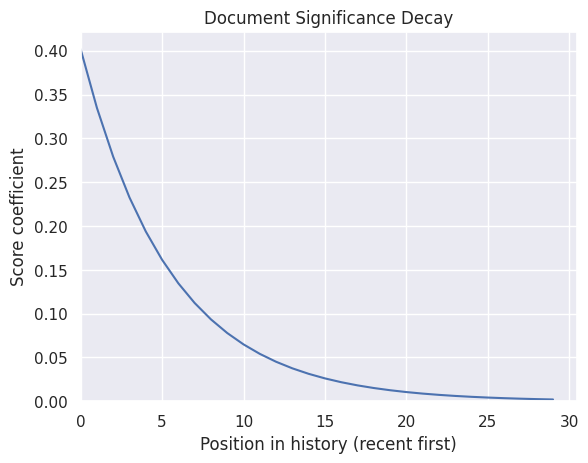

In [102]:
# History with 30 documents
x = np.arange(0, 30)
y = decay(x)

plt.plot(x, y)
plt.title("Document Significance Decay")
plt.xlabel("Position in history (recent first)")
plt.ylabel("Score coefficient")
plt.xlim(0)
plt.ylim(0);

In this project, we use exponential decay.

## Interesting statistics

#### General stats

Here you can see general statistics over the whole database:

In [103]:
print("Number of documents", len(docs))
print("Vocabulary size", len(index.tfidf.columns))
print("Average number of tokens", (index.bow).sum(1).mean())
print(
    "Average number of words",
    sum([len(doc.text.split()) for doc in docs]) / len(docs),
)

Number of documents 1000
Vocabulary size 75321
Average number of tokens 4953.793
Average number of words 8388.342


#### Most frequent terms

Here we present analysis by terms:

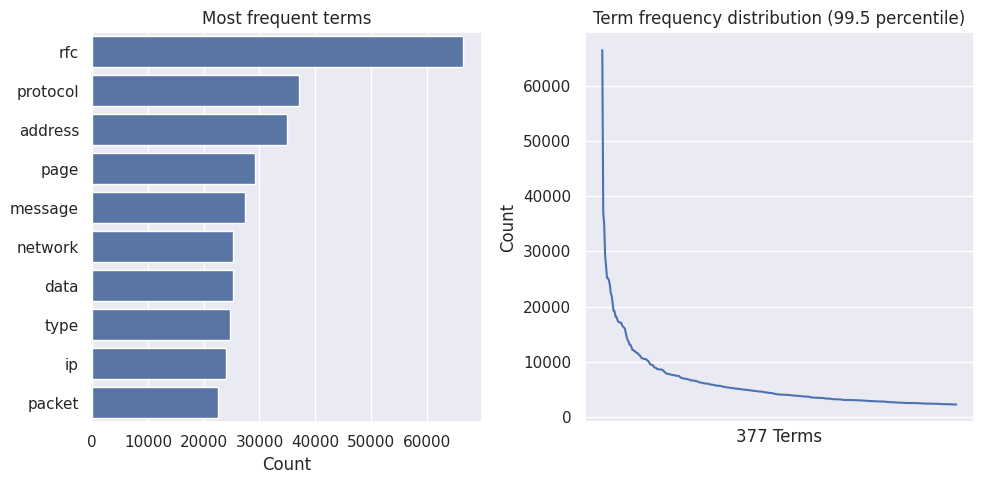

In [149]:
limit_output = 10

_, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Most frequent terms")
axes[0].set_xlabel("Count")
sns.barplot(
    index.bow.sum().sort_values()[::-1][:limit_output], orient="h", ax=axes[0]
)

term_frequencies = index.bow.sum().sort_values(ascending=False)
percentile_n = 99.5
percentile = np.percentile(term_frequencies, percentile_n)
term_frequencies = term_frequencies[term_frequencies > percentile]

axes[1].set_title(f"Term frequency distribution ({percentile_n} percentile)")
axes[1].set_xlabel(f"{len(term_frequencies)} Terms")
axes[1].set_ylabel("Count")
axes[1].set_xticks([])

sns.lineplot(term_frequencies, ax=axes[1])
plt.tight_layout()

#### Most important terms

Instead of counting words, we can check their importance:

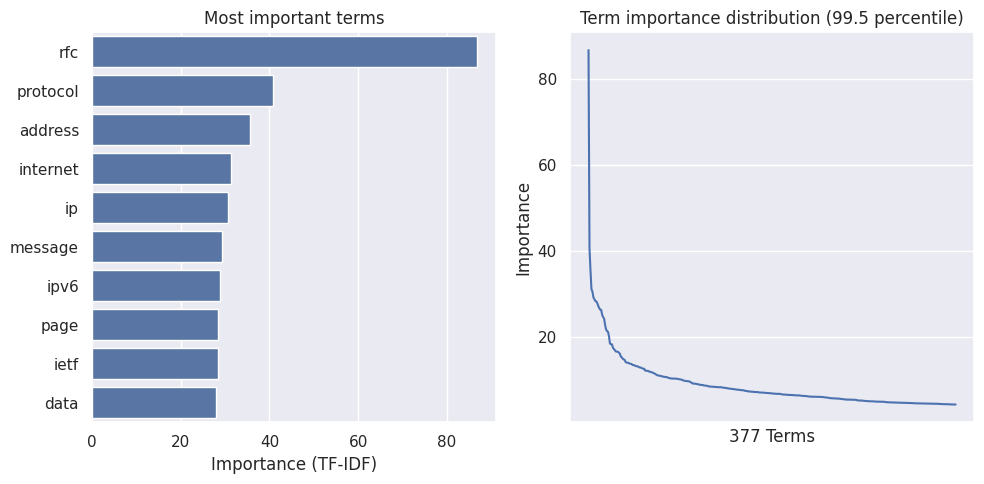

In [146]:
limit_output = 10

_, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Most important terms")
axes[0].set_xlabel("Importance (TF-IDF)")
sns.barplot(
    index.tfidf.sum().sort_values()[::-1][:limit_output],
    orient="h",
    ax=axes[0],
)

term_frequencies = index.tfidf.sum().sort_values(ascending=False)
percentile_n = 99.5
percentile = np.percentile(term_frequencies, percentile_n)
term_frequencies = term_frequencies[term_frequencies > percentile]

axes[1].set_title(f"Term importance distribution ({percentile_n} percentile)")
axes[1].set_xlabel(f"{len(term_frequencies)} Terms")
axes[1].set_ylabel("Importance")
axes[1].set_xticks([])

sns.lineplot(term_frequencies, ax=axes[1])
plt.tight_layout()

Even though the data is aggregated and the IDF is now effectively vanished (hence no dramatic changes compared to regular BOW), still the logarithm seems to smooth distribution.

#### Document similarity

It is also interesting to observe how different are documents that happen to be parsed in different moments in time.

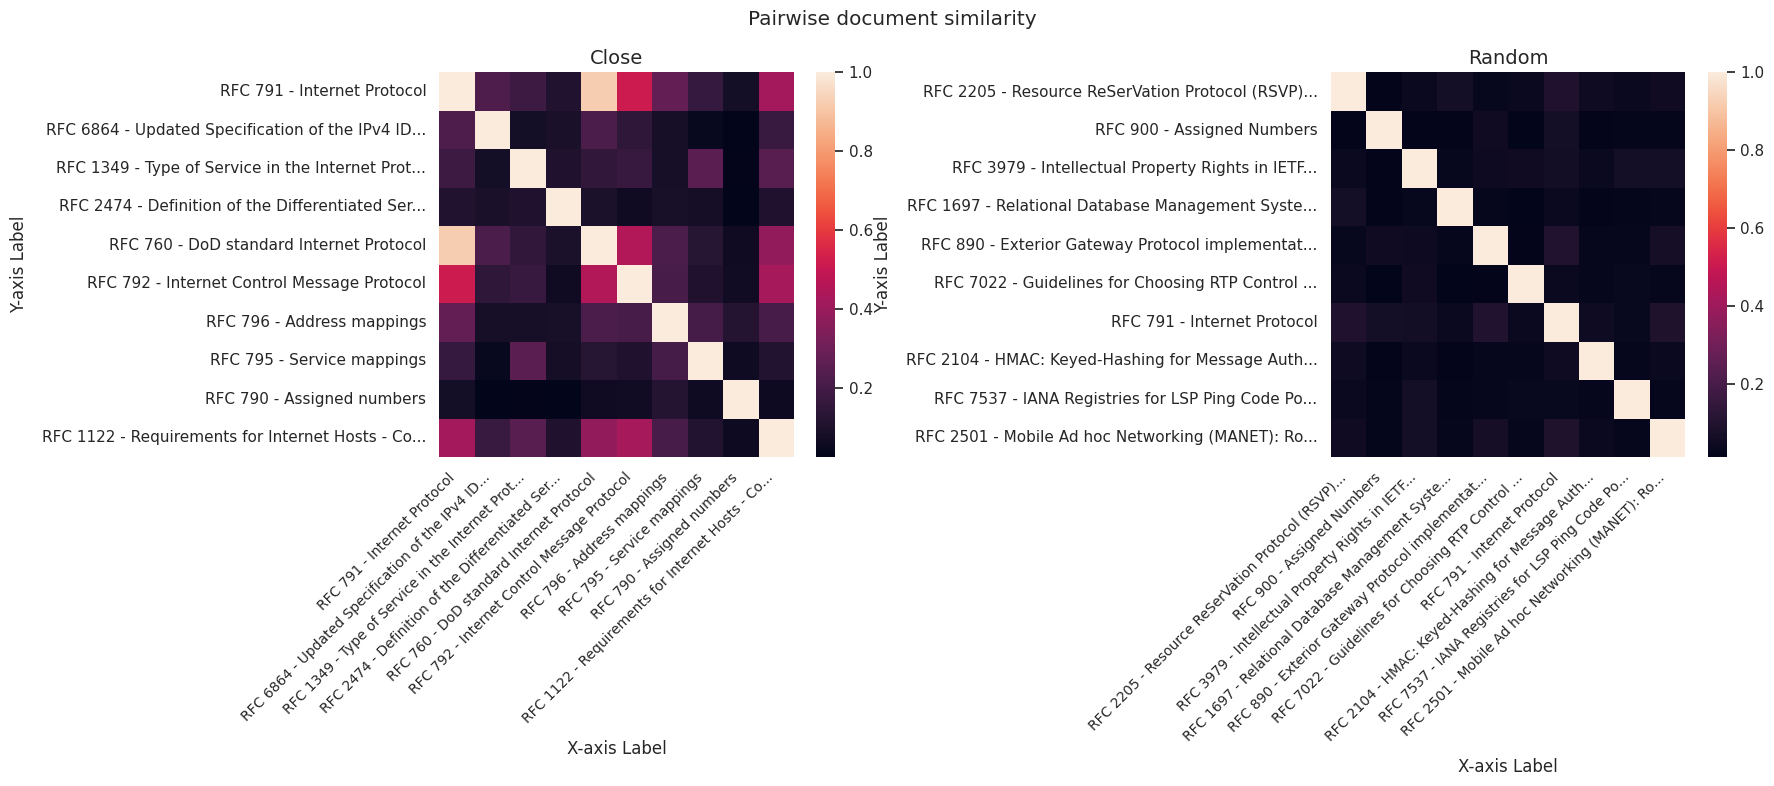

In [107]:
limit_output = 10

# Get random indices
np.random.seed(21)
random_indices = np.arange(len(docs))
np.random.shuffle(random_indices)
random_indices = random_indices[:limit_output]

selected_indices = [
    (np.arange(limit_output), "Close"),
    (random_indices, "Random"),
]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Pairwise document similarity")

for i, (indices, label) in enumerate(selected_indices):
    selected_docs = [docs[i] for i in indices]
    names = []
    scores = []
    for doc in selected_docs:
        if len(doc.name) > 50:
            name = doc.name[:47] + "..."
            names.append(name)
        else:
            names.append(doc.name)

        ranked = index.query_docs([DocQuery(doc)], sort=False)[0]
        scores.append([ranked[i].rank for i in indices])
    scores = np.array(scores)

    sns.heatmap(scores, yticklabels=names, ax=axes[i])
    axes[i].set_title(label, fontsize=14)
    axes[i].set_xlabel("X-axis Label", fontsize=12, labelpad=10)
    axes[i].set_ylabel("Y-axis Label", fontsize=12, labelpad=10)
    axes[i].tick_params(axis="x", rotation=45, labelsize=10)
    axes[i].set_xticklabels(names, ha="right")
plt.tight_layout()

Since documents were stored in the order they were scraped (i.e. DFS), **adjacent documents** are likely to have **more in common** than those that were drawn randomly. 

## Examples

### Wikipedia

The example shows that the recommendation system can work with a different source while maintaining useful features.

Let's retrieve recommended documents from the following articles:

In [108]:
limit_output = 10
query = [
    UrlQuery("https://en.wikipedia.org/wiki/User_Datagram_Protocol"),
    UrlQuery("https://en.wikipedia.org/wiki/IPv6"),
    UrlQuery("https://en.wikipedia.org/wiki/Jumbogram"),
]

Logger.setLevel("WARNING")
fetched, queried = index.query_docs(query, decay=decay, skip_visited=True)
print(("\n".join(map(str, fetched[:limit_output]))))
Logger.setLevel("INFO")

0.354 RFC 1933 - Transition Mechanisms for IPv6 Hosts and Routers: https://datatracker.ietf.org/doc/html/rfc1933
0.340 RFC 4942 - IPv6 Transition/Co-existence Security Considerations: https://datatracker.ietf.org/doc/html/rfc4942
0.334 RFC 2893 - Transition Mechanisms for IPv6 Hosts and Routers: https://datatracker.ietf.org/doc/html/rfc2893
0.329 RFC 2765 - Stateless IP/ICMP Translation Algorithm (SIIT): https://datatracker.ietf.org/doc/html/rfc2765
0.313 RFC 2460 - Internet Protocol, Version 6 (IPv6) Specification: https://datatracker.ietf.org/doc/html/rfc2460
0.312 RFC 4213 - Basic Transition Mechanisms for IPv6 Hosts and Routers: https://datatracker.ietf.org/doc/html/rfc4213
0.309 RFC 1883 - Internet Protocol, Version 6 (IPv6) Specification: https://datatracker.ietf.org/doc/html/rfc1883
0.306 RFC 6936 - Applicability Statement for the Use of IPv6 UDP Datagrams with Zero Checksums: https://datatracker.ietf.org/doc/html/rfc6936
0.303 RFC 4038 - Application Aspects of IPv6 Transition: 

* There are some duplications, however they are different RFCs - they are different versions.
* `Applicability Statement for the Use of IPv6 UDP Datagrams with Zero Checksums` - this article **combines** both `IPv6` and `User_Datagram_Protocol`
* `IPv6 Jumbograms` were also retrieved, **interplaying** with `IPv6`

Combine results into a dataframe for further plotting:

In [109]:
# Create df from fetched docs
combined_docs = fetched[limit_output:] + queried + fetched[:limit_output]
labels = (
    ["Irrelevant"] * (len(fetched) - limit_output)
    + ["Queried"] * len(queried)
    + ["Relevant"] * limit_output
)

fetched_df = pd.DataFrame(
    [doc.vector for doc in combined_docs],
    index=[doc.url for doc in combined_docs],
    columns=index.tfidf.columns,
)

# Transform
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tfidf_matrix = tsne.fit_transform(fetched_df)
tfidf_df = pd.DataFrame(tfidf_matrix, columns=["Component 1", "Component 2"])

Plot the results:

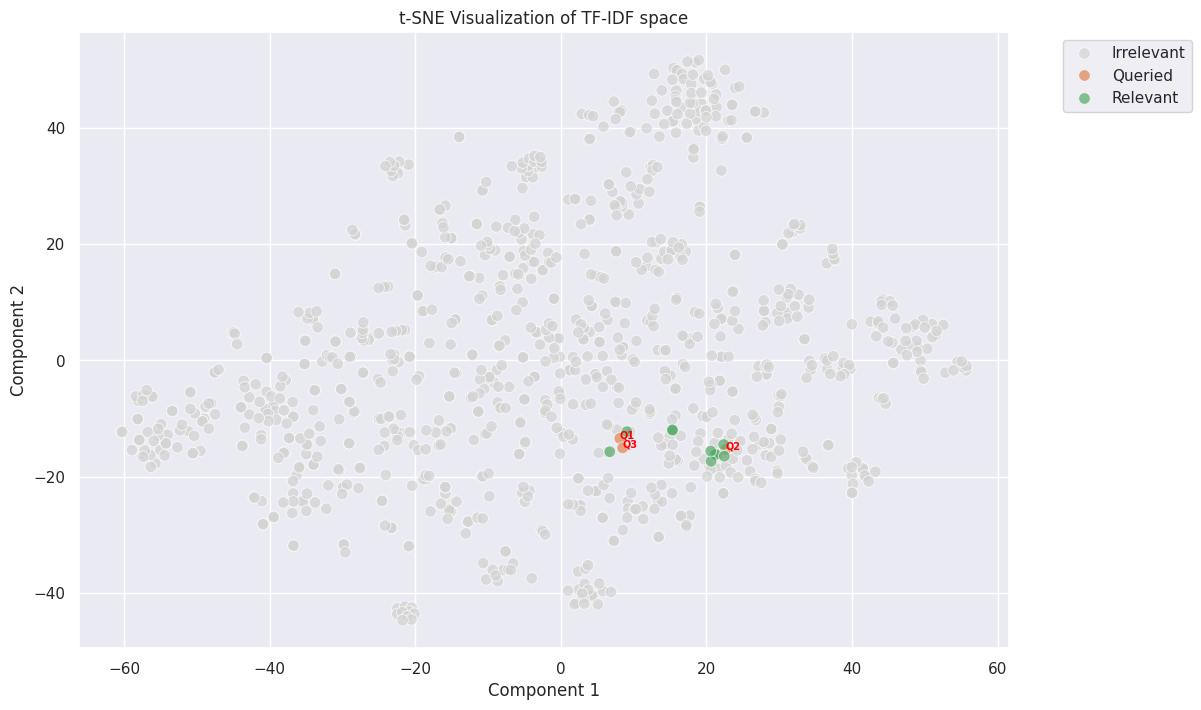

In [110]:
# Scatter
custom_palette = sns.color_palette()[:3]
custom_palette[0] = "lightgray"
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="Component 1",
    y="Component 2",
    data=tfidf_df,
    hue=labels,
    palette=custom_palette,
    s=70,
    alpha=0.7,
)

# Annotate
queried_points = tfidf_df.iloc[
    (len(fetched) - limit_output) : -limit_output
].reset_index()
for i, row in queried_points.iterrows():
    plt.text(
        row["Component 1"],
        row["Component 2"],
        f"Q{i + 1}",
        color="red",
        fontsize=7,
        weight="bold",
    )


plt.title("t-SNE Visualization of TF-IDF space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Queried documents:
* `Q1` - UDP
* `Q2` - IPv6
* `Q3` - Jumbograms

You can see that even though the history of the document should lean towards the `UDP` (it was the last visited document), still `IPv6` is under more profound discussion, and supposedly it matches in-database documents better.

### Term importance

In this section, we delve into term comparison. To make it easier, here is the 

In [134]:
doc = index.to_doc(NameQuery("The MD4 Message-Digest Algorithm"))
fetched = index.query_docs([DocQuery(doc)], skip_visited=True)[0][:3]
print("\n".join(map(str, fetched)))

0.794 RFC 1321 - The MD5 Message-Digest Algorithm: https://datatracker.ietf.org/doc/html/rfc1321
0.258 RFC 3174 - US Secure Hash Algorithm 1 (SHA1): https://datatracker.ietf.org/doc/html/rfc3174
0.256 RFC 1115 - Privacy enhancement for Internet electronic mail: Part III - algorithms, modes, and identifiers: https://datatracker.ietf.org/doc/html/rfc1115


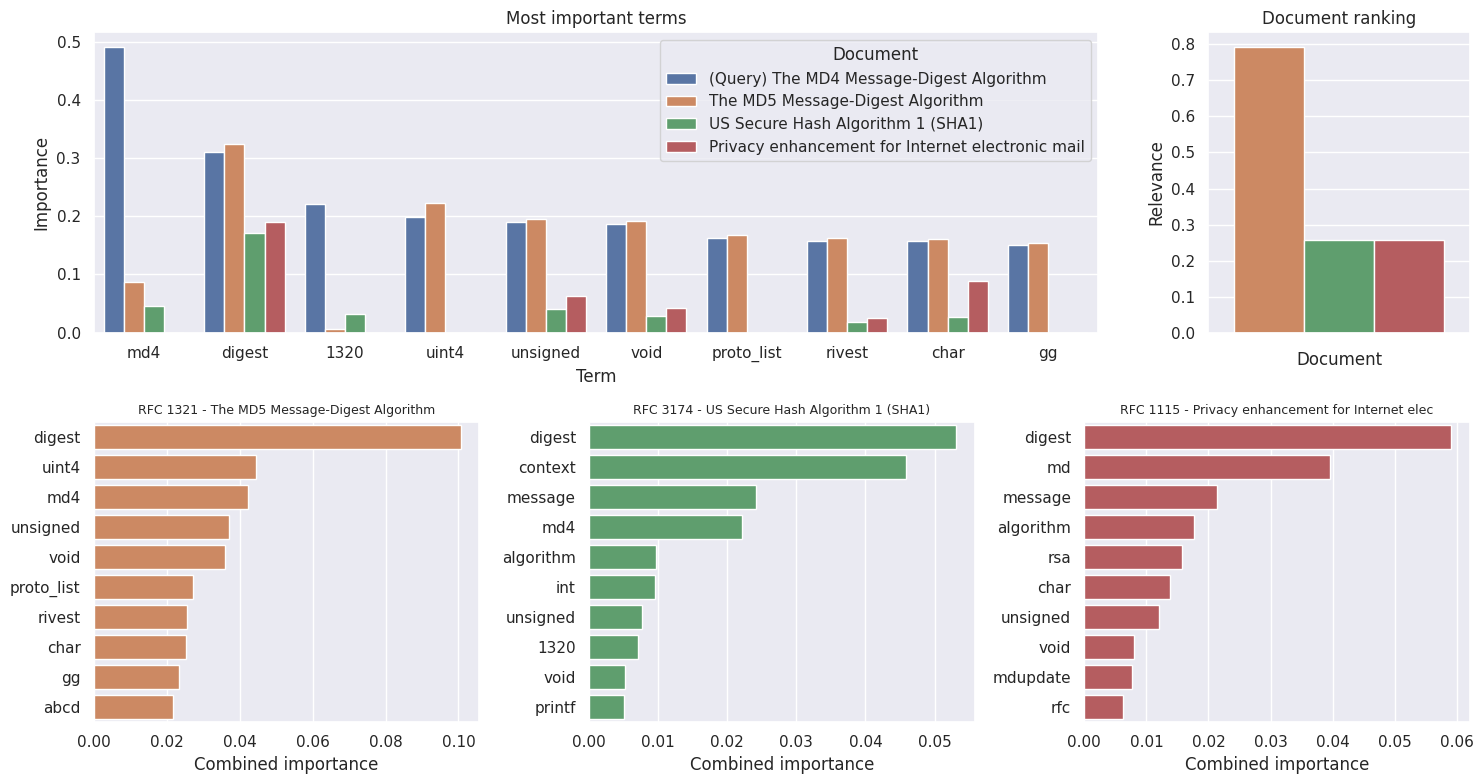

In [135]:
# Get top terms
top_terms = index.tfidf.loc[doc.url].sort_values()[::-1][:limit_output].index

# Fetch the those terms for all docs
dfs = []
for doc_ in [doc] + fetched:
    df = pd.DataFrame(index.tfidf.loc[doc_.url]).loc[top_terms].reset_index()
    df.rename(columns={doc_.url: "value"}, inplace=True)
    name = doc_.name[11:][:48]
    if doc_.url == doc.url:
        name = "(Query) " + name
    df["Document"] = name
    dfs.append(df)

# Combine
new_df = pd.concat(dfs)


# Plot
fig = plt.figure(figsize=(15, 8))

ax = plt.subplot2grid((2, 12), (0, 0), colspan=9)
sns.barplot(new_df, x="index", y="value", hue="Document", ax=ax)
ax.set_title("Most important terms")
ax.set_xlabel("Term")
ax.set_ylabel("Importance")

ax = plt.subplot2grid((2, 12), (0, 9), colspan=3)
sns.barplot(
    hue=[i for i in range(len(fetched))],
    y=[doc_.rank for doc_ in fetched],
    legend=False,
    palette=sns.color_palette()[1:4],
    ax=ax,
)
ax.set_title("Document ranking")
ax.set_xlabel("Document")
ax.set_ylabel("Relevance")

for i, doc_ in enumerate(fetched):
    combined = index.tfidf.loc[doc.url] * index.tfidf.loc[doc_.url]
    combined = combined.sort_values()[::-1][:10]
    ax = plt.subplot2grid((2, 12), (1, i * 4), colspan=4)
    ax.set_title(doc_.name[:48], fontsize=9)
    ax.set_xlabel("Combined importance")
    sns.barplot(combined, ax=ax, orient="h", color=sns.color_palette()[i + 1])

plt.tight_layout()

The top left plot describes comparison of the top terms of the query document (`MD4`) with values that correspond to this terms in retrieved documents.

The top right plot describes the rankings of the retrieved documents.

3 bottom plots show the combination of TF-IDF of query and TF-IDF of the retrieved document. While it does not affect results in general, plot is interesting to be shown.


Observations:
* We can see how close `MD4` and `MD5` are: their term importances are almost identical (for the given terms).
* Other two documents share practically the same similarity to the query, although their top-term combination differ noticeably.

## Document / History importance

In [136]:
limit_output = 10
query = [
    NameQuery("The PPP AppleTalk Control Protocol (ATCP)"),
    NameQuery("The NULL Encryption Algorithm and Its Use With IPsec"),
    NameQuery("Discard Protocol"),
    # NameQuery("Traditional IP Network Address Translator (Traditional NAT)"),
]
no_decay = lambda x: np.ones_like(x)  # noqa: E731
fetched, queried = index.query_docs(query, decay=decay, skip_visited=True)
fetched = fetched[:limit_output]
print(("\n".join(map(str, fetched))))

0.198 RFC 2406 - IP Encapsulating Security Payload (ESP): https://datatracker.ietf.org/doc/html/rfc2406
0.196 RFC 1243 - AppleTalk Management Information Base: https://datatracker.ietf.org/doc/html/rfc1243
0.192 RFC 2411 - IP Security Document Roadmap: https://datatracker.ietf.org/doc/html/rfc2411
0.187 RFC 862 - Echo Protocol: https://datatracker.ietf.org/doc/html/rfc862
0.172 RFC 1332 - The PPP Internet Protocol Control Protocol (IPCP): https://datatracker.ietf.org/doc/html/rfc1332
0.170 RFC 4305 - Cryptographic Algorithm Implementation Requirements for Encapsulating Security Payload (ESP) and Authentication Header (AH): https://datatracker.ietf.org/doc/html/rfc4305
0.161 RFC 866 - Active users: https://datatracker.ietf.org/doc/html/rfc866
0.160 RFC 2407 - The Internet IP Security Domain of Interpretation for ISAKMP: https://datatracker.ietf.org/doc/html/rfc2407
0.160 RFC 4303 - IP Encapsulating Security Payload (ESP): https://datatracker.ietf.org/doc/html/rfc4303
0.159 RFC 1331 - Th

In [137]:
queried_names = [
    "AppleTalk Control Protocol",
    "Null Encryption with IPsec",
    "Discard Protocol",
]

fetched_names = [
    "IP Encapsulating Security Payload",
    "AppleTalk Management Information",
    "IP Security Document Roadmap",
    "Echo Protocol",
    "Protocol Control Protocol",
    "Cryptographic Algorithm Implementation",
    "Active users",
    "Security Domain for ISAKMP",
    "_IP Encapsulating Security Payload",
    "PPP for the Multi-protocol Datagrams",
]

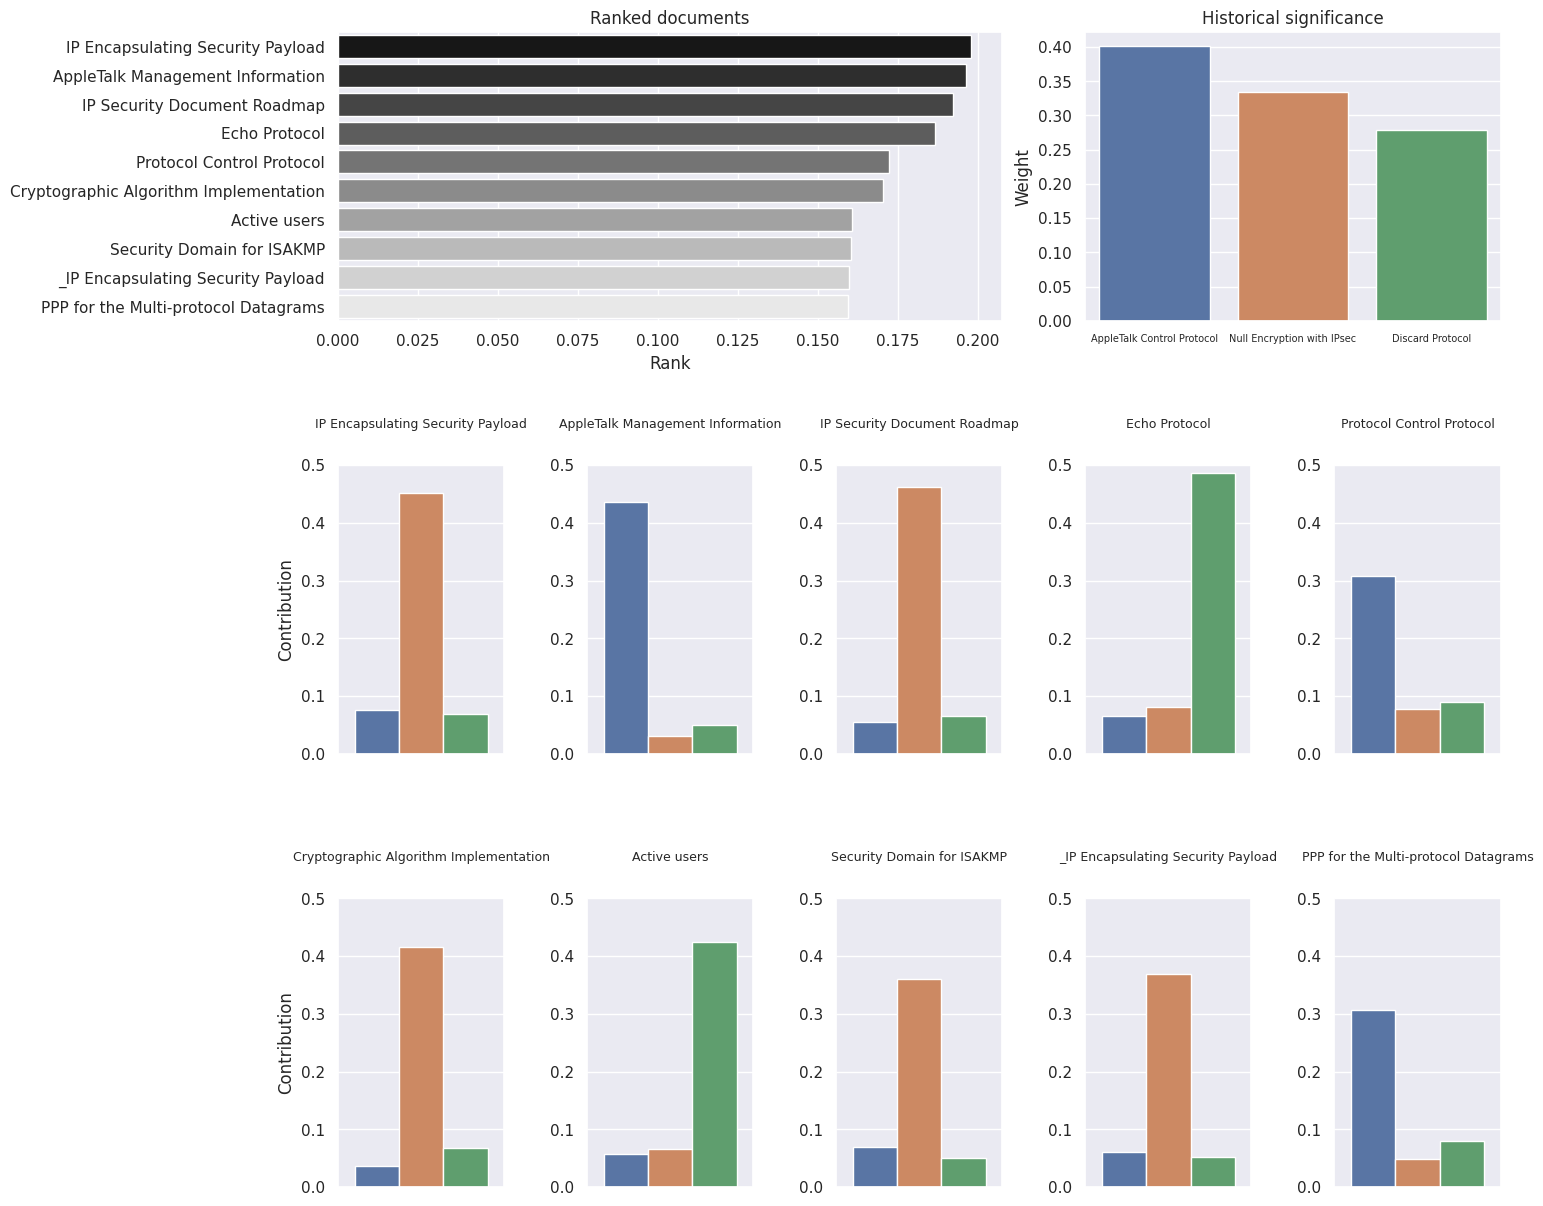

In [139]:
fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax = plt.subplot2grid((3, 5), (0, 0), colspan=3)
sns.barplot(
    x=[doc_.rank for doc_ in fetched],
    y=fetched_names,
    legend=False,
    palette=sns.color_palette("gray", n_colors=10),
    ax=ax,
)
ax.set_title("Ranked documents")
ax.set_xlabel("Rank")


ax = plt.subplot2grid((3, 5), (0, 3), colspan=2)
sns.barplot(
    hue=[i for i in range(len(query))],
    y=decay(np.arange(len(query))),
    x=queried_names,
    legend=False,
    palette=sns.color_palette()[:3],
    ax=ax,
)
plt.setp(ax.get_xticklabels(), fontsize=7)
ax.set_ylabel("Weight")
ax.set_title("Historical significance")

for i in range(2):
    for j in range(5):
        ax = plt.subplot2grid((3, 5), (i + 1, j))
        sns.barplot(
            hue=[i for i in range(len(query))],
            y=fetched[i * 5 + j].similarities,
            legend=False,
            palette=sns.color_palette()[:3],
            ax=ax,
        )
        ax.set_title(fetched_names[i * 5 + j], fontsize=9, y=1.1)
        if j == 0:
            ax.set_ylabel("Contribution")
        ax.set_ylim(0, 0.5)

The top left plot describes ranking of retrieved documents. 

Top right shows that the order of the document matters - the latest the document was viewed in the history, the more impact on calculating relevance is.

Bottom plots show how each document in the query contribute to the document ranking.